# Imported Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model #GARCH Models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import math
from statistics import NormalDist
from scipy.stats import t
from datetime import datetime
from scipy.stats import shapiro #Shapiro Test
from scipy import stats #t-test
import statsmodels.api as sm #Ljung-Box Test
from scipy.stats import chi2
import os

In [2]:
dir_name = "/Users/raph/Desktop/Data/"
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))

# Data

In [3]:
start_date = '2006-01-01' #yyyy-mm-dd
end_date = '2021-01-01'


#Philippines
PH = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/PSEi.csv')
PH['Date'] = pd.to_datetime(PH['Date'])
PH = PH.rename(columns={'Price': 'Close'})
PH = PH.replace(',','', regex=True)
PH['Close'] = PH['Close'].astype(float, errors = 'raise')
mask = (PH['Date'] >= start_date) & (PH['Date'] <= end_date)
PH = PH.loc[mask]
PH = PH.set_index('Date')
PH = PH.sort_index(axis=0, ascending = False)
#Malaysia
MY = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/%5EKLSE.csv')
MY['Date'] = pd.to_datetime(MY['Date'])
MY = MY.rename(columns={'Price': 'Close'})
MY = MY.replace(',','', regex=True)
MY['Close'] = MY['Close'].astype(float, errors = 'raise')
mask = (MY['Date'] >= start_date) & (MY['Date'] <= end_date)
MY = MY.loc[mask]
MY = MY.set_index('Date')
MY = MY.sort_index(axis=0, ascending = False).dropna()

#Signapore
SG = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/STI.csv')
SG['Date'] = pd.to_datetime(SG['Date'])
SG = SG.replace(',','', regex=True)
SG['Close'] = SG['Close'].astype(float, errors = 'raise')
mask = (SG['Date'] >= start_date) & (SG['Date'] <= end_date)
SG = SG.loc[mask]
SG= SG.set_index('Date')
SG = SG.sort_index(axis=0, ascending = False).dropna()

#Thailand
TH = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/SETi.csv')
TH['Date'] = pd.to_datetime(TH['Date'])
TH = TH.rename(columns={'Price': 'Close'})
TH = TH.replace(',','', regex=True)
TH['Close'] = TH['Close'].astype(float, errors = 'raise')
mask = (TH['Date'] >= start_date) & (TH['Date'] <= end_date)
TH = TH.loc[mask]
TH= TH.set_index('Date')
TH = TH.sort_index(axis=0, ascending = False).dropna()

#Vietnam
VT = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/HNX.csv')
VT['Date'] = pd.to_datetime(VT['Date'])
VT = VT.rename(columns={'Price': 'Close'})
VT = VT.replace(',','', regex=True)
VT['Close'] = VT['Close'].astype(float, errors = 'raise')
mask = (VT['Date'] >= start_date) & (VT['Date'] <= end_date)
VT = VT.loc[mask]
VT= VT.set_index('Date')
VT = VT.sort_index(axis=0, ascending = False).dropna()

# Logarithmic Returns

In [4]:
def get_returns(df,d):
    '''
    The function obtains the log returns of the asset shifted d days
    
    PARAMETERS
    ----------
    df : pandas.DataFrame
        The data frame contains data of a chosen stock index 
        (Stock index must be arrange in DESCENDING ORDER by DATE)
    d : int
        The dth day being forecast
        (Assumed to be 1 for most cases)
        
    RETURNS
    -------
    df : pandas.DataFrame
        The data frame returns an updated data frame containing the
        'Returns' column
    '''
    df['Previous'] = df['Close'].shift(-d)
    df['Returns'] = np.log(df['Close']/df['Previous'])*100
    return df.dropna(subset = ['Returns'], how = 'all')

PH = get_returns(PH, 1)
MY = get_returns(MY, 1)
SG = get_returns(SG, 1)
TH = get_returns(TH, 1)
VT = get_returns(VT, 1)

# Determining the Order of the GARCH Model (Standard is GARCH(1, 1))
## Parameters

In [5]:
alpha = 0.05
vol = 'EGARCH'
p = 1
q = 1

In [6]:
def fit_params(df, vol,  p = None, q = None):
    returns = df['Returns']
    model = arch_model(returns, vol = vol, p = p, q = q, rescale = False)
    fit = model.fit(disp = 'off')
    params = fit.params
    resid = fit.resid
    condv = fit.conditional_volatility
    return fit, params, resid, condv

PH_fit_e, PH_params_e, PH_resid_e, PH_condv_e = fit_params(PH, vol, p, q)
MY_fit_e, MY_params_e, MY_resid_e, MY_condv_e = fit_params(MY, vol, p, q)
SG_fit_e, SG_params_e, SG_resid_e, SG_condv_e = fit_params(SG, vol, p, q)
TH_fit_e, TH_params_e, TH_resid_e, TH_condv_e = fit_params(TH, vol, p, q)
VT_fit_e, VT_params_e, VT_resid_e, VT_condv_e = fit_params(VT, vol, p, q)

# Verifying Order Determination (Ljung-Box Test)

In [7]:
#Philippines
print(sm.stats.acorr_ljungbox((PH_resid_e**2).dropna(), lags=[20], return_df=True))

#Malaysia
print(sm.stats.acorr_ljungbox((MY_resid_e**2).dropna(), lags=[20], return_df=True))

#Singapore
print(sm.stats.acorr_ljungbox((SG_resid_e**2).dropna(), lags=[20], return_df=True))

#Thailand
print(sm.stats.acorr_ljungbox((TH_resid_e**2).dropna(), lags=[20], return_df=True))

#Vietnam
print(sm.stats.acorr_ljungbox((VT_resid_e**2).dropna(), lags=[20], return_df=True))

      lb_stat      lb_pvalue
20  1242.5402  5.914415e-251
       lb_stat      lb_pvalue
20  715.963833  9.256399e-139
        lb_stat  lb_pvalue
20  5177.550868        0.0
        lb_stat      lb_pvalue
20  1025.184738  1.658924e-204
        lb_stat  lb_pvalue
20  3214.394977        0.0


# Estimating VaR 
## Obtaining the volatility


In [5]:
def get_VaR_EGARCH(df, alpha, sigma, dist):
    if dist == 'normal':
        VaR = sigma*NormalDist().inv_cdf(1-alpha) #t.ppf(1-alpha, len(df['Returns'])-1 )
    elif dist == 't':
        VaR = sigma*t.ppf(1-alpha, len(df['Returns'])-1 )
#     display(round(VaR,5))
    return VaR


# #Philippines
# PH_VaR_t = get_VaR_EGARCH(PH, alpha, PH_sigma_c, dist)

# #Malaysia
# MY_VaR_t = get_VaR_EGARCH(MY, alpha, MY_sigma_c, dist)

# #Singapore
# SG_VaR_t = get_VaR_EGARCH(SG, alpha, SG_sigma_c, dist)


# #Thailand
# TH_VaR_t = get_VaR_EGARCH(TH, alpha, TH_sigma_c, dist)

# #Vietnam
# VT_VaR_t = get_VaR_EGARCH(VT, alpha, VT_sigma_c, dist)
def no_to_test(df, prediction_size):
    return int(np.ceil(len(df)*prediction_size))


# Fixed Window
## Parameters

In [31]:
prediction_size = 0.1
alpha = 0.0001
vol = 'EGARCH'
d = 1
dist = 'normal'
p = 1
q = 1
name = 'FW-E-0.01%'

In [32]:
def fixed_window(df, test_size, d, alpha, p, q, vol, dist):
    test_size = no_to_test(df, prediction_size)
    date_df = df.iloc[:test_size]
    date_df = date_df.reset_index()
    date_df = date_df.filter(['Date'])
    df = df[::-1]
    returns = df['Returns']
    sigma_df = np.zeros((test_size, 1))
    for i in range(test_size):
        temp_df = returns[i:-(test_size-i)]
        model = arch_model(temp_df, p=p, q=q, vol = vol, rescale=None)
        fit = model.fit(disp='off')
        pred = fit.forecast(horizon=d, reindex = False)
        sigma_df[i] = (np.sqrt(pred.variance.values[-1,:][0]))
    sigma_df = pd.DataFrame(sigma_df[::-1], columns = ['Volatility'])
    sigma_df = pd.merge(date_df, sigma_df, left_index = True, right_index = True)
    sigma_df.set_index('Date', inplace = True)
    VaR_df = get_VaR_EGARCH(df, alpha, sigma_df, dist)
    return sigma_df, VaR_df


PH_sigma_df_e, PH_fw_df_e = fixed_window(PH, prediction_size,d, alpha,p,q, vol, dist)
MY_sigma_df_e, MY_fw_df_e = fixed_window(MY, prediction_size,d, alpha,p,q, vol, dist)
SG_sigma_df_e, SG_fw_df_e = fixed_window(SG, prediction_size,d, alpha,p,q, vol, dist)
TH_sigma_df_e, TH_fw_df_e = fixed_window(TH, prediction_size,d, alpha,p,q, vol, dist)
VT_sigma_df_e, VT_fw_df_e = fixed_window(VT, prediction_size,d, alpha,p,q, vol, dist)

# VaR Violations FW

In [33]:
def char_function(df, window, test_size, name):
    '''
    The function returns the number of VaR violations.
    
    PARAMETERS
    ----------
    df : pandas.DataFrame
        The data frame contains data of a} chosen stock index 
        (Stock index must be arrange in DESCENDING ORDER by DATE)
        (Data frames must be the same size)
    window : pandas.DataFrame
        The data frame contains the estimated (1-alpha)% d-day VaR from 
        time t = test size to current using the rolling time window 
        (Data frames must be the same size)
        
    RETURNS
    -------
    N : int
        The value is the number of VaR violations
    '''
#     returns = abs(df['Returns'][:test_size].dropna())
    test_size = no_to_test(df, prediction_size)
    returns = df['Returns'][:test_size]
    f_returns = window.values
    N = 0
    violation_lst = []
    for i, j in zip(returns, f_returns):
        if i < -j :
            violation_lst.append(1)
            N += 1 
        else:
            violation_lst.append(0)
    violations = pd.Series(violation_lst, index = returns.index, name = name)
    df = df.join(violations)
    display(N)
    return df, N

#Philippines
PH, PH_N_fw_e = char_function(PH, PH_fw_df_e, prediction_size, name)

#Malaysia
MY, MY_N_fw_e = char_function(MY, MY_fw_df_e, prediction_size, name)

#Singapore
SG, SG_N_fw_e = char_function(SG, SG_fw_df_e, prediction_size, name)
    
#Thailand
TH, TH_N_fw_e = char_function(TH, TH_fw_df_e, prediction_size, name)

#Vietnam
VT, VT_N_fw_e = char_function(VT, VT_fw_df_e, prediction_size, name)

2

3

2

6

2

# Visualization of the Fixed Window

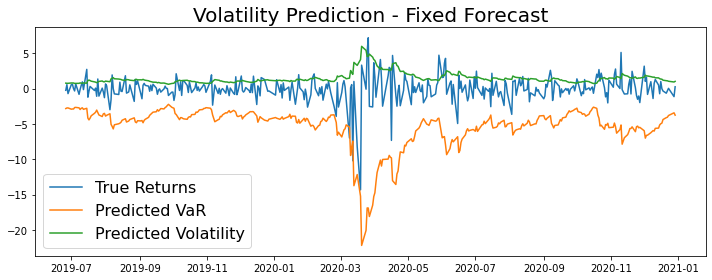

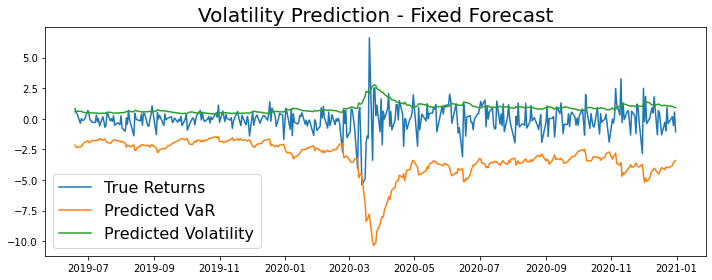

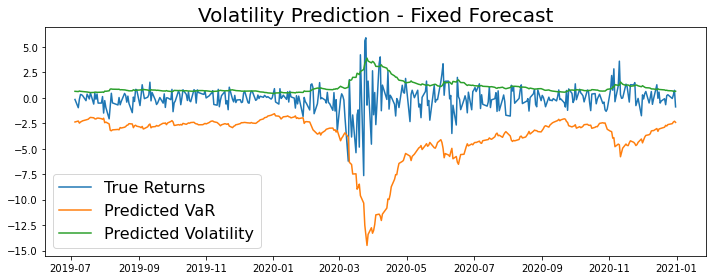

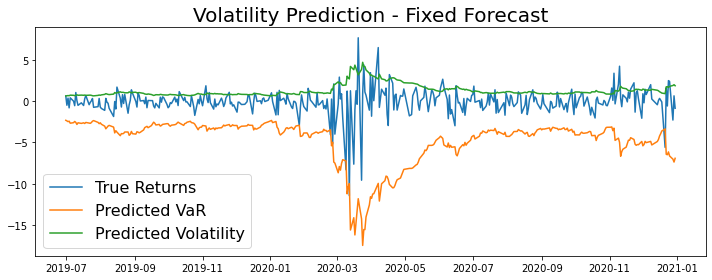

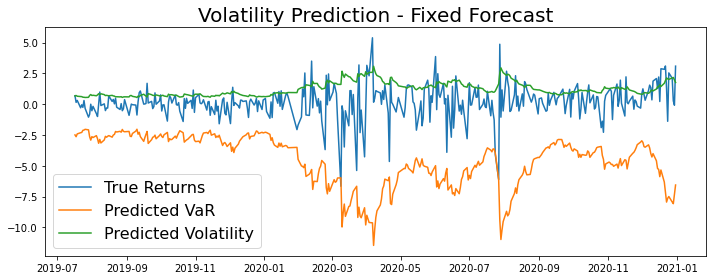

In [34]:
#Standard

#Philippines
plt.figure(figsize=(10,4))
plt.plot(PH['Returns'][:no_to_test(PH,prediction_size)])
plt.plot(-PH_fw_df_e)
plt.plot(PH_sigma_df_e)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('PH_'+name+'.png')


#Malaysia
plt.figure(figsize=(10,4))
plt.plot(MY['Returns'][:no_to_test(MY,prediction_size)])
plt.plot(-MY_fw_df_e)
plt.plot(MY_sigma_df_e)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('MY_'+name+'.png')

#Singapore
plt.figure(figsize=(10,4))
plt.plot(SG['Returns'][:no_to_test(SG,prediction_size)])
plt.plot(-SG_fw_df_e)
plt.plot(SG_sigma_df_e)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('SG_'+name+'.png')

#Thailand
plt.figure(figsize=(10,4))
plt.plot(TH['Returns'][:no_to_test(TH,prediction_size)])
plt.plot(-TH_fw_df_e)
plt.plot(TH_sigma_df_e)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('TH_'+name+'.png')

#Vietnam
plt.figure(figsize=(10,4))
plt.plot(VT['Returns'][:no_to_test(VT,prediction_size)])
plt.plot(-VT_fw_df_e)
plt.plot(VT_sigma_df_e)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('VT_'+name+'.png')

# Rolling Window
## Parameters

In [35]:
prediction_size = 0.1
alpha = 0.0001
d = 1
p = 1
q = 1
dist = 'normal'
vol = 'EGARCH'
name = 'RW-E-0.01%'

In [36]:
def rolling_window(df, test_size, d, alpha, p, q, vol, dist):
    test_size = no_to_test(df, prediction_size)
    date_df = df.iloc[:test_size]
    date_df = date_df.reset_index()
    date_df = date_df.filter(['Date'])
    df = df[::-1]
    returns = df['Returns']
    sigma_df = np.zeros((test_size, 1))
    for i in range(test_size):
        temp_df = returns[:-(test_size-i)]
        model = arch_model(temp_df, p=p, q=q, vol = vol , rescale=None)
        fit = model.fit(disp='off')
        pred = fit.forecast(horizon=d, reindex = False)
        sigma_df[i] = (np.sqrt(pred.variance.values[-1,:][0]))
    sigma_df = pd.DataFrame(sigma_df[::-1], columns = ['Volatility'])
    sigma_df = pd.merge(date_df, sigma_df, left_index = True, right_index = True)
    sigma_df.set_index('Date', inplace = True)
    VaR_df = get_VaR_EGARCH(df, alpha, sigma_df, dist)
    return sigma_df, VaR_df

PH_sigma_df_e, PH_rw_df_e = rolling_window(PH, prediction_size,d, alpha,p,q, vol, dist)
MY_sigma_df_e, MY_rw_df_e = rolling_window(MY, prediction_size,d, alpha,p,q, vol, dist)
SG_sigma_df_e, SG_rw_df_e = rolling_window(SG, prediction_size,d, alpha,p,q, vol, dist)
TH_sigma_df_e, TH_rw_df_e = rolling_window(TH, prediction_size,d, alpha,p,q, vol, dist)
VT_sigma_df_e, VT_rw_df_e = rolling_window(VT, prediction_size,d, alpha,p,q, vol, dist)


# VaR Violation RW

In [37]:
#Philippines
PH, PH_N_rw_e = char_function(PH, PH_rw_df_e, prediction_size, name)

#Malaysia
MY, MY_N_rw_e = char_function(MY, MY_rw_df_e, prediction_size, name)

#Singapore
SG, SG_N_rw_e = char_function(SG, SG_rw_df_e, prediction_size, name)
    
#Thailand
TH, TH_N_rw_e = char_function(TH, TH_rw_df_e, prediction_size, name)

#Vietnam
VT, VT_N_rw_e = char_function(VT, VT_rw_df_e, prediction_size, name)

2

3

2

6

2

# Visualization of the Rolling Window

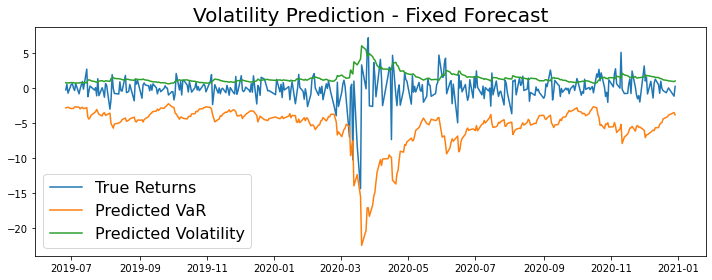

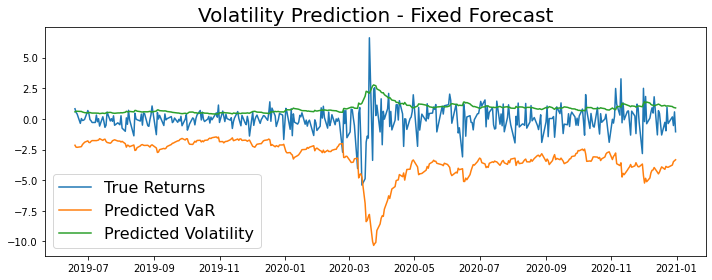

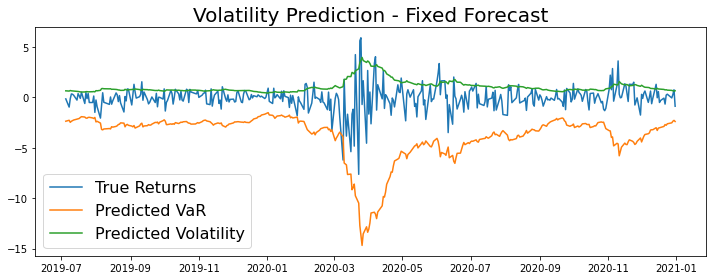

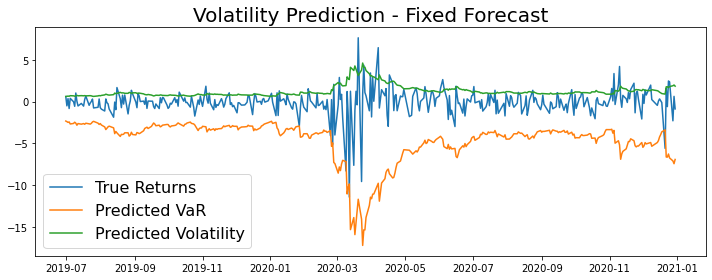

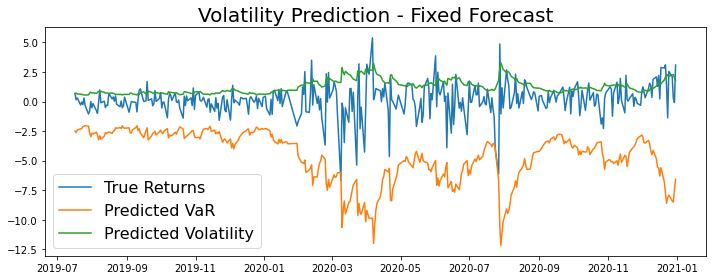

In [38]:
#Standard

#Philippines
plt.figure(figsize=(10,4))
plt.plot(PH['Returns'][:no_to_test(PH,prediction_size)])
plt.plot(-PH_rw_df_e)
plt.plot(PH_sigma_df_e)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('PH_'+name+'.png')


#Malaysia
plt.figure(figsize=(10,4))
plt.plot(MY['Returns'][:no_to_test(MY,prediction_size)])
plt.plot(-MY_rw_df_e)
plt.plot(MY_sigma_df_e)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('MY_'+name+'.png')

#Singapore
plt.figure(figsize=(10,4))
plt.plot(SG['Returns'][:no_to_test(SG,prediction_size)])
plt.plot(-SG_rw_df_e)
plt.plot(SG_sigma_df_e)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('SG_'+name+'.png')

#Thailand
plt.figure(figsize=(10,4))
plt.plot(TH['Returns'][:no_to_test(TH,prediction_size)])
plt.plot(-TH_rw_df_e)
plt.plot(TH_sigma_df_e)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('TH_'+name+'.png')

#Vietnam
plt.figure(figsize=(10,4))
plt.plot(VT['Returns'][:no_to_test(VT,prediction_size)])
plt.plot(-VT_rw_df_e)
plt.plot(VT_sigma_df_e)
plt.title('Volatility Prediction - Fixed Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted VaR', 'Predicted Volatility'], fontsize=16)
plt.savefig('VT_'+name+'.png')

# Suffieincy of the Model


## Unconditional Coverage

In [19]:
def CI_UC(alpha, ss):
    '''
    The function returns an (1-alpha)% confidence interval for N
    
    PARAMETERS
    ----------
    alpha : float 
        The level of significance of the VaR
        (Assumes a value in between 0 and 1)
    ss : int
        The total number of entries in the data frame of the asset
        
    RETURNS
    -------
    CI : list
        The list is the (1-alpha)% confidence interval
    '''
    CI = []
    a = np.ceil(alpha*ss - (NormalDist().inv_cdf(1-alpha/2))*np.sqrt(ss*alpha*(1-alpha)))
    b = np.ceil(alpha*ss + (NormalDist().inv_cdf(1-alpha/2))*np.sqrt(ss*alpha*(1-alpha)))
    CI.append(a)
    CI.append(b)
    return CI


print(CI_UC(alpha,test_size))


[-1.0, 9.0]


## Chi-squared Test (1 DoF)

In [20]:
chi2.ppf(1-alpha, df = 1)

6.6348966010212145

## Conditional Coverage

In [21]:
chi2.ppf(1-alpha, df = 2)

9.21034037197618

# Parameters

In [39]:
alpha = 0.0001
entries1 = no_to_test(PH, prediction_size)
entries2 = no_to_test(MY, prediction_size)
entries3 = no_to_test(SG, prediction_size)
entries4 = no_to_test(TH, prediction_size)
entries5 = no_to_test(VT, prediction_size)
name_1 = 'FW-E-0.01%'
name_2 = 'RW-E-0.01%'


# Kupiec Test

In [40]:
def LR_kupiec(N, observations, alpha):
    p = alpha
    a =-2*np.log((((1-p)**(observations - N))*(p**N))/(((1-N/observations)**(observations - N))*((N/observations)**N)))
    display(round(a,4))
    return a



#Philippines
PH_LRk_fw_e = LR_kupiec(PH_N_fw_e,entries1, alpha)
PH_LRk_rw_e = LR_kupiec(PH_N_rw_e,entries1, alpha)

#Malaysia
MY_LRk_fw_e = LR_kupiec(MY_N_fw_e, entries2, alpha)
MY_LRk_rw_e = LR_kupiec(MY_N_rw_e, entries2, alpha)

#Singapore
SG_LRk_fw_e = LR_kupiec(SG_N_fw_e, entries3, alpha)
SG_LRk_rw_e = LR_kupiec(SG_N_rw_e, entries3, alpha)

#Thailand
TH_LRk_fw_e = LR_kupiec(TH_N_fw_e, entries4, alpha)
TH_LRk_rw_e = LR_kupiec(TH_N_rw_e, entries4, alpha)

#Vietnam
VT_LRk_fw_e = LR_kupiec(VT_N_fw_e, entries5, alpha)
VT_LRk_rw_e = LR_kupiec(VT_N_rw_e, entries5, alpha)

12.0872

12.0872

20.2962

20.2962

11.9811

11.9811

49.3317

49.3317

12.0337

12.0337

# Christoffersen Test
## Part 1

In [41]:
def no_of_periods(df, name):
    n00 = 0
    n01 = 0
    n10 = 0
    n11 = 0
    violations = df[name].dropna()[::-1]
    v_p = violations[0]
    i = 1
    while i < len(violations):
        if v_p == violations[i] and v_p == 0:
            n00 += 1
        elif v_p != violations[i] and v_p == 0:
            n01 += 1
        elif v_p != violations[i] and v_p == 1:
            n10 += 1
        else:
            n11 += 1
        v_p = violations[i]
        i += 1 
    return n00, n01, n10, n11


## Part 2

In [42]:
def LR_ind(df, name, LR_pof):
    n00, n01, n10, n11 = no_of_periods(df, name)
    pi_0 = n01/(n00+n01)
    pi_1 = n11/(n10+n11)
    pi = (n01+n11)/(n00+n01+n10+n11)
    LR_ind = -2*np.log((((1-pi)**(n00+n01))*(pi**(n01+n11)))/(((1-pi_0)**n00)*(pi_0**n01)*((1-pi_1)**n10)*(pi_1**n11)))
    LR_cc = LR_ind+LR_pof
    display(round(LR_cc,4))
    return LR_ind, LR_cc

#Philippines
PH_LRcci_fw_e, PH_LRcc_fw_e = LR_ind(PH, name_1, PH_LRk_fw_e)
PH_LRcci_rw_e, PH_LRcc_rw_e = LR_ind(PH, name_2, PH_LRk_rw_e)
#Malaysia
MY_LRcci_fw_e, MY_LRcc_fw_e = LR_ind(MY, name_1, MY_LRk_fw_e)
MY_LRcci_rw_e, MY_LRcc_rw_e = LR_ind(MY, name_2, MY_LRk_rw_e)
#Singapore
SG_LRcci_fw_e,SG_LRcc_fw_e= LR_ind(SG, name_1, SG_LRk_fw_e)
SG_LRcci_rw_e,SG_LRcc_rw_e= LR_ind(SG, name_2, SG_LRk_rw_e)
#Thailand
TH_LRcci_fw_e,TH_LRcc_fw_e= LR_ind(TH, name_1, TH_LRk_fw_e)
TH_LRcci_rw_e,TH_LRcc_rw_e= LR_ind(TH, name_2, TH_LRk_rw_e)
#Vietnem
VT_LRcci_fw_e,VT_LRcc_fw_e= LR_ind(VT, name_1, VT_LRk_fw_e)
VT_LRcci_rw_e,VT_LRcc_rw_e= LR_ind(VT, name_2, VT_LRk_rw_e)

12.1092

12.1092

20.344

20.344

12.0025

12.0025

49.5317

49.5317

12.0555

12.0555

### Conditional

In [8]:
def sigma_c(df_1, df_2, model_param, p, q):
    omega = model_param[1]
    if p != None:
        i = 0
        alpha_lst = []
        while i < len(model_param) - (q+2):
            alpha = model_param[i+2]
            alpha_lst.append(alpha)
            i += 1
    if q != None:
        i = 0
        beta_lst = []
        while i < len(model_param) - (p+2):
            beta = model_param[i+2+p]
            beta_lst.append(beta)
            i += 1
    sigma = omega
    i = 0
    for alpha in alpha_lst:
        sigma += alpha*(df_1.iloc[i]**2)
        i += 1
    i = 0
    for beta in beta_lst:
        sigma += beta*(df_2.iloc[i]**2)
        i += 1
    return np.sqrt(sigma)


PH_sigma_c = sigma_c(PH_resid_e, PH_condv_e, PH_params_e, p = 1, q = 1)
MY_sigma_c = sigma_c(MY_resid_e, MY_condv_e, MY_params_e, p = 1, q = 1)
SG_sigma_c = sigma_c(SG_resid_e, SG_condv_e, SG_params_e, p = 1, q = 1)
TH_sigma_c = sigma_c(TH_resid_e, TH_condv_e, TH_params_e, p = 1, q = 1)
VT_sigma_c = sigma_c(VT_resid_e, VT_condv_e, VT_params_e, p = 1, q = 1)